# Implementing a Variational Autoencoder

### Generative models model a distribution of data over high dimensional space



![Image of Yaktocat](https://blog.openai.com/content/images/2017/02/gen_models_diag_2.svg)

### Autoencoders are a type of generative model

![Image of Yaktocat](https://image.slidesharecdn.com/pydatanyc2015torresfinal-151111035917-lva1-app6891/95/deep-style-using-variational-autoencoders-for-image-generation-37-638.jpg?cb=1447260130)



### Problems
- They will overfit unless large training data
- Gradients diminish quickly so weight updates get progressively smaller the farther we go from the output (vanishing gradient)

### Solution
- Add a variational component to regularize training

![Image of Yaktocat](http://www.fastforwardlabs.com/blog-images/miriam/imgs_code/vae.4.png)

- VAEs were introduces 3 years ago
- they are built on top of standard function approximators (neural networks), and can be trained with SGD
- simple neural nets can represent a wide variety of interesting functions when given appropriate parameters
- VAE examples 
- pokemon https://github.com/musicmilif/Pokemon-Generator/blob/master/VAE.ipynb
- faces https://github.com/ahmed-touati/vanilla_vae

In [42]:
import numpy as np #matrix math
import tensorflow as tf #machine 
import glob
import cv2
import os
import re
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
print(tf.__version__)

1.0.1


In [43]:


# Import MINST data
#The MNIST data is split into three parts: 55,000 data points of training data 
#10,000 points of test data and 5,000 points of validation data 
#very MNIST data point has two parts: an image of a handwritten digit 
#and a corresponding label. 
#We'll call the images "x" and the labels "y". 
#Both the training set and test set contain images and their corresponding labels; 
orig_img = np.empty((0, 32, 32), dtype='float32')
# Load all images and append into orig_img
path = os.path.abspath("./demo.ipynb")
path = re.sub('[a-zA-Z\s._]+$', '', path)
for pic in glob.glob(path+'/train/digit_0/*.png'):
    img = mpimg.imread(pic)
    orig_img = np.append(orig_img, [img], axis=0)

for pic in glob.glob(path+'/train/digit_1/*.png'):
    img = mpimg.imread(pic)
    orig_img = np.append(orig_img, [img], axis=0)

for pic in glob.glob(path+'/train/digit_2/*.png'):
    img = mpimg.imread(pic)
    orig_img = np.append(orig_img, [img], axis=0)

for pic in glob.glob(path+'/train/digit_3/*.png'):
    img = mpimg.imread(pic)
    orig_img = np.append(orig_img, [img], axis=0)

for pic in glob.glob(path+'/train/digit_4/*.png'):
    img = mpimg.imread(pic)
    orig_img = np.append(orig_img, [img], axis=0)

X_flat = orig_img
X_flat = np.reshape(X_flat,(10000-5, 1024))

In [44]:
np.random.shuffle(X_flat)
print np.shape(X_flat)

(9995, 1024)


In [45]:
#Each image is 28 pixels by 28 pixels. We can interpret this as a big array of numbers:
n_pixels = 32*32
# Input to the graph -- Tensorflow's MNIST images are (1, 784) vectors
#x isn’t a specific value. 
#It’s a placeholder, a value that we’ll input when we ask TensorFlow 
#to run a computation. We want to be able to input any number of MNIST images, 
#each flattened into a 784-dimensional vector. We represent this as a 2-D tensor of 
#floating-point numbers
X = tf.placeholder(tf.float32, shape=([None, n_pixels]))

In [46]:
#layer creation functions
#we could do this inline but cleaner to wrap it in respective functions

#represent the strength of connections between units.
def weight_variable(shape, name):
    #Outputs random values from a truncated normal distribution.
    #truncated means the value is either bounded below or above (or both)
    initial = tf.truncated_normal(shape, stddev=0.1)
    #A Variable is a modifiable tensor that lives in TensorFlow’s graph of 
    #interacting operations. It can be used and even modified by the computation. 
    #For machine learning applications, one generally has the model parameters 
    #be Variables.
    return tf.Variable(initial, name=name)

#Bias nodes are added to increase the flexibility of 
#the model to fit the data. Specifically, it allows the 
#network to fit the data when all input features are equal to 00, 
#and very likely decreases the bias of the fitted values elsewhere in the data space
def bias_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

#Neurons in a fully connected layer have full connections to 
#all activations in the previous layer, as seen in regular Neural Networks. 
#Their activations can hence be computed with a matrix multiplication followed by a 
#bias offset. 
def FC_layer(X, W, b):
    return tf.matmul(X, W) + b

## Encoder
The encoder consists of a 2 layer, fully connected feed forward network that reduces the dimensionality from the original number of features (e.g. pixel) to the dimensionality of the latent space. This network has two outputs -- the mean and (log) standard deviation of a gaussian distribution.

![Image of Yaktocat](https://cdn-images-1.medium.com/max/2000/1*op0VO_QK4vMtCnXtmigDhA.png)

In [47]:
# encoder
#our VAE model can parse the information spread thinly over the high-dimensional 
#observed world of pixels, and condense the most meaningful features into a 
#structured distribution over reduced (20) latent dimensions
#latent = embedded space, we just see latent used in stochastic models in papers a lot
#latent means not directly observed but are rather inferred
latent_dim = 128
#num neurons
h_dim = 500

#layer 1
W_enc = weight_variable([n_pixels, h_dim], 'W_enc')
b_enc = bias_variable([h_dim], 'b_enc')
# tanh activation function to replicate original model
#The tanh function, a.k.a. hyperbolic tangent function, 
#is a rescaling of the logistic sigmoid, such that its outputs range from -1 to 1.
#tanh or sigmoid? Whatever avoids the vanishing gradient problem!
h_enc = tf.nn.tanh(FC_layer(X, W_enc, b_enc))

#layer 2
W_mu = weight_variable([h_dim, latent_dim], 'W_mu')
b_mu = bias_variable([latent_dim], 'b_mu')
mu = FC_layer(h_enc, W_mu, b_mu) #mean

#instead of the encoder generating a vector of real values, 
#it will generate a vector of means and a vector of standard deviations.
#for reparamterization
W_logstd = weight_variable([h_dim, latent_dim], 'W_logstd')
b_logstd = bias_variable([latent_dim], 'b_logstd')
logstd = FC_layer(h_enc, W_logstd, b_logstd)

# reparameterization trick - lets us backpropagate successfully
#since normally gradient descent expects deterministic nodes
#and we have stochastic nodes
#distribution
noise = tf.random_normal([1, latent_dim])
#sample from the standard deviations (tf.exp computes exponential of x element-wise) 
#and add the mean 
#this is our latent variable we will pass to the decoder
z = mu + tf.multiply(noise, tf.exp(.5*logstd))
#The greater standard deviation on the noise added, 
#the less information we can pass using that one variable.
#The more efficiently we can encode the original image, 
#the higher we can raise the standard deviation on our gaussian until it reaches one.
#This constraint forces the encoder to be very efficient, 
#creating information-rich latent variables. 
#This improves generalization, so latent variables that we either randomly generated, 
#or we got from encoding non-training images, will produce a nicer result when decoded.

## Decoder

The decoder (or, in the language of LFADS, the 'generator') is also a feedforward, fully connected network -- however, it goes from the dimensionality of the latent space back to the original dimensionality of the data (e.g. pixels). The output of the network is squashed between 0 and 1 with a sigmoid function.

In [48]:
# decoder

#layer 1
W_dec = weight_variable([latent_dim, h_dim], 'W_dec')
b_dec = bias_variable([h_dim], 'b_dec')
#pass in z here (and the weights and biases we just defined)
h_dec = tf.nn.tanh(FC_layer(z, W_dec, b_dec))


#layer 2, using the original n pixels here since thats the dimensiaonlty
#we want to restore our data to
W_reconstruct = weight_variable([h_dim, n_pixels], 'W_reconstruct')
b_reconstruct = bias_variable([n_pixels], 'b_reconstruct')
#784 bernoulli parameters output
reconstruction = tf.nn.sigmoid(FC_layer(h_dec, W_reconstruct, b_reconstruct))

## Loss function
Each of these outputs is taken to be the mean of a Bernoulli distribution (in this example, a Bernoulli distribution is appropriate because our data is binary). The variational lower bound is given by:

\begin{equation}
\mathcal{L} = \mathbb{E}_{z\sim Q(z|X)}\log P(X|z) - D(Q(z|X)||P(z))
\end{equation}

When $P$ is a Bernouli distribution, the log likelihood is given by

\begin{equation}
\log P(X|z) = \sum_i^N X^{(i)}\log y^{(i)} + (1 − X^{(i)}) \cdot \log(1 − y^{(i)})
\end{equation}

where $N$ is the number of training samples (in our case, the batchsize), and $y^{(i)}$ is the reconstruction from the latent code $z^{(i)}$. The KL divergence between a gaussian $Q$ with mean $\mu$ and standard deviation $\sigma$ and a standard normal distribution $P$ is given by:

\begin{equation}
D(Q||P) = -\frac{1}{2}\sum_j^J \big(1 + \log((\sigma_j)^2) - (\mu_j)^2 - (\sigma_j)^2\big)
\end{equation}

We want to maximize this lower bound, but because tensorflow doesn't have a 'maximizing' optimizer, we minimize the negative lower bound.

In [49]:
#lets define our loss function

# variational lower bound

# add epsilon to log to prevent numerical overflow
#Information is lost because it goes from a smaller to a larger dimensionality. 
#How much information is lost? We measure this using the reconstruction log-likelihood 
#This measure tells us how effectively the decoder has learned to reconstruct
#an input image x given its latent representation z.
log_likelihood = tf.reduce_sum(X*tf.log(reconstruction + 1e-9)+(1 - X)*tf.log(1 - reconstruction + 1e-9), reduction_indices=1)
#KL Divergence
#If the encoder outputs representations z that are different 
#than those from a standard normal distribution, it will receive 
#a penalty in the loss. This regularizer term means 
#‘keep the representations z of each digit sufficiently diverse’. 
#If we didn’t include the regularizer, the encoder could learn to cheat
#and give each datapoint a representation in a different region of Euclidean space. 
KL_term = -.5*tf.reduce_sum(1 + 2*logstd - tf.pow(mu,2) - tf.exp(2*logstd), reduction_indices=1)

# This allows us to use stochastic gradient descent with respect to the variational parameters
variational_lower_bound = tf.reduce_mean(log_likelihood - KL_term)
optimizer = tf.train.AdadeltaOptimizer().minimize(-variational_lower_bound)

## Training

Now all we have to do is run the optimizer until convergence. 

In [50]:
#init all variables and start the session!
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
## Add ops to save and restore all the variables.
saver = tf.train.Saver()

In [56]:
import time #lets clock training time..
model_name = 0
num_iterations = 10000
recording_interval = 1000
batch_size=200
total_batch = int(X_flat.shape[0]/batch_size)
#store value for these 3 terms so we can plot them later
variational_lower_bound_array = []
log_likelihood_array = []
KL_term_array = []
iteration_array = [i*recording_interval for i in range(num_iterations/recording_interval)]
for i in range(num_iterations):
    # np.round to make MNIST binary
    #get first batch (200 digits)
    print "hello"+str(i)
    start = 0; end = batch_size
    for j in range(total_batch-1):
        index = np.arange(start, end)
        np.random.shuffle(index)
        x_batch = np.round(X_flat[index])
        start = end
        end = start+batch_size
        sess.run(optimizer, feed_dict={X: x_batch})
    #run our optimizer on our data
    if (i%recording_interval == 0):
        #every 1K iterations record these values
        vlb_eval = variational_lower_bound.eval(feed_dict={X: x_batch})
        print "Iteration: {}, Loss: {}".format(i, vlb_eval)
        variational_lower_bound_array.append(vlb_eval)
        log_likelihood_array.append(np.mean(log_likelihood.eval(feed_dict={X: x_batch})))
        KL_term_array.append(np.mean(KL_term.eval(feed_dict={X: x_batch})))
        model_name = i
        save_path = saver.save(sess, "/home/parth/ml/vae/model/model"+str(i)+".ckpt")
        print("Model saved in file: %s" % save_path)

hello0
Iteration: 0, Loss: -1144.3371582
Model saved in file: /home/parth/ml/vae/model/model0.ckpt
hello1
hello2
hello3
hello4
hello5
hello6
hello7
hello8
hello9
hello10
hello11
hello12
hello13
hello14
hello15
hello16
hello17
hello18
hello19
hello20
hello21
hello22
hello23
hello24
hello25
hello26
hello27
hello28
hello29
hello30
hello31
hello32
hello33
hello34
hello35
hello36
hello37
hello38
hello39
hello40
hello41
hello42
hello43
hello44
hello45
hello46
hello47
hello48
hello49
hello50
hello51
hello52
hello53
hello54
hello55
hello56
hello57
hello58
hello59
hello60
hello61
hello62
hello63
hello64
hello65
hello66
hello67
hello68
hello69
hello70
hello71
hello72
hello73
hello74
hello75
hello76
hello77
hello78
hello79
hello80
hello81
hello82
hello83
hello84
hello85
hello86
hello87
hello88
hello89
hello90
hello91
hello92
hello93
hello94
hello95
hello96
hello97
hello98
hello99
hello100
hello101
hello102
hello103
hello104
hello105
hello106
hello107
hello108
hello109
hello110
hello111
hello112
h

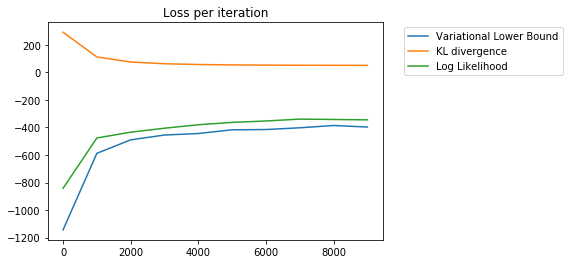

In [57]:
plt.figure()
#for the number of iterations we had 
#plot these 3 terms
plt.plot(iteration_array, variational_lower_bound_array)
plt.plot(iteration_array, KL_term_array)
plt.plot(iteration_array, log_likelihood_array)
plt.legend(['Variational Lower Bound', 'KL divergence', 'Log Likelihood'], bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Loss per iteration')

## Results

Here, we plot the reconstructed image on test set images.

/home/parth/ml/vae/
lol
lol
lol
lol
lol
lol
lol
lol
lol
lol
(10, 32, 32)
(1, 1024)
(1, 1024)
(1, 1024)
(1, 1024)
(1, 1024)


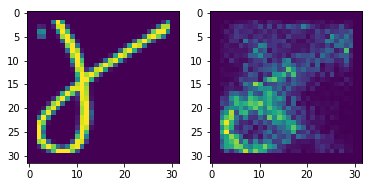

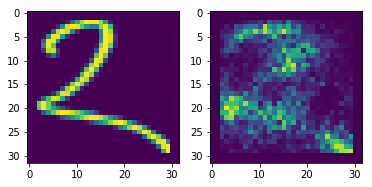

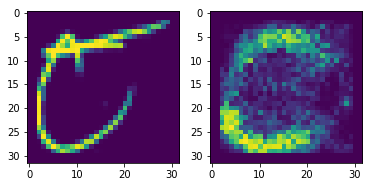

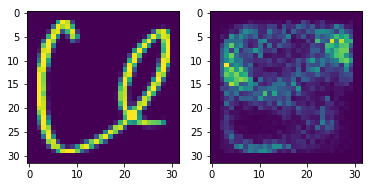

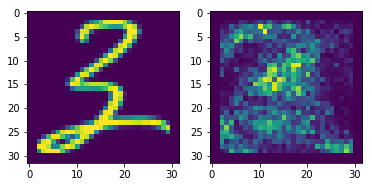

In [60]:
import numpy as np #matrix math
import tensorflow as tf #machine 
import glob
import cv2
import os
import re
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
n_pixels = 1024
load_model = True
if load_model:
    saver.restore(sess, "/home/parth/ml/vae/model/model"+str(9000)+".ckpt")

path = os.path.abspath("./demo.ipynb")
path = re.sub('[a-zA-Z\s._]+$', '', path)
print path

t_img = np.empty((0, 32, 32), dtype='float32')

for pic in glob.glob(path+'/Test/*.png'):
    img = mpimg.imread(pic)
    t_img = np.append(t_img, [img], axis=0)
    print "lol"

print np.shape(t_img)
num_pairs = 5
#Lets plot 5 digits
for pair in range(5):
    #reshaping to show original test image
    x = np.reshape(t_img[pair], (1,n_pixels))
    print np.shape(x)
    plt.figure()
    x_image = np.reshape(x, (32,32))
    plt.subplot(121)
    plt.imshow(x_image)
    #reconstructed image, feed the test image to the decoder
    x_reconstruction = reconstruction.eval(feed_dict={X: x})
    #reshape it to 28x28 pixels
    x_reconstruction_image = (np.reshape(x_reconstruction, (32,32)))
    #plot it!
    plt.subplot(122)
    plt.imshow(x_reconstruction_image)